In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nu6xaqad
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-nu6xaqad
  Resolved https://github.com/tensorflow/docs to commit e21d085d5ed82504ffcec11aa82ebc78f1f2302e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=18e877deabee890acb4422349322b0da4a708e2ead181d554654fb4990f5f9a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_f9yj31/wheels/3e/88/34/48d2789bc9d37b33ddce06bccc454fae0285e5396d0a5be9d9
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

ZBIÓR DANYCH HIGGSA

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz','https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2814820352/Unknown 737s 0us/step

In [7]:
FEATURES = 28

In [8]:
ds = tf.data.experimental.CsvDataset(gz,[float()]*(FEATURES+1),compression_type="GZIP")

In [9]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [10]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


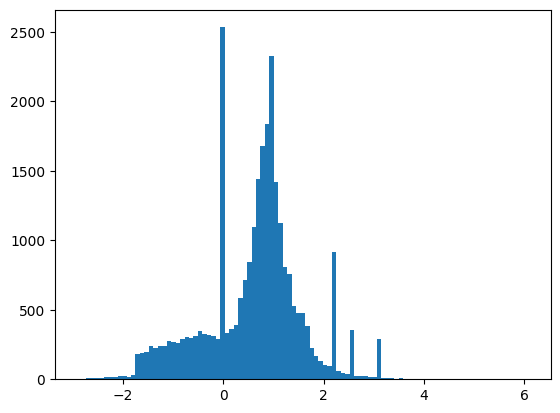

In [11]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [12]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = int(N_TRAIN/BATCH_SIZE)

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [14]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [16]:
print(validate_ds.counter)

<function DatasetV2.counter at 0x79202ba4da80>


PRZYGOTOWANIE MODELU DO PREZENTACJI OVERFITTINGU

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

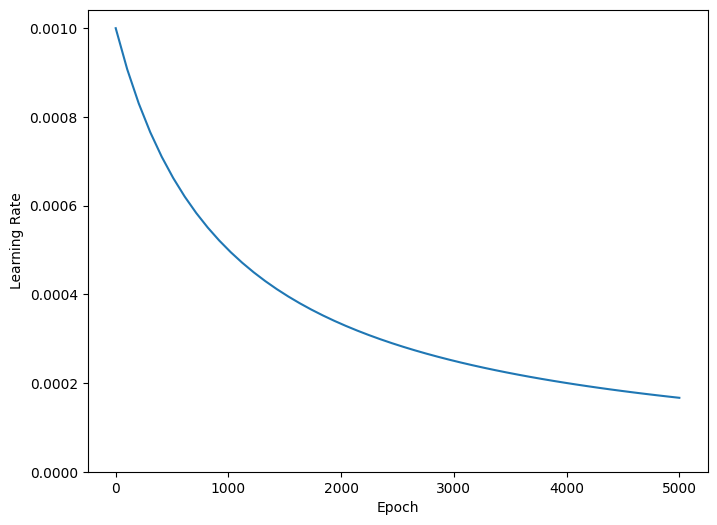

In [18]:
step = np.linspace(0,100_000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [19]:
def get_callbacks(name):
  return [
      tfdocs.modeling.EpochDots(),
      tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
      tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [20]:
def compile_and_fit(model,name,optimizer=None,max_epochs = 10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer = optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True, name='binary_crossentropy'
                    ),'accuracy'
                ])
  model.summary()
  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs = max_epochs,
      validation_data = validate_ds,
      callbacks = get_callbacks(name),
      verbose=0
  )
  return history

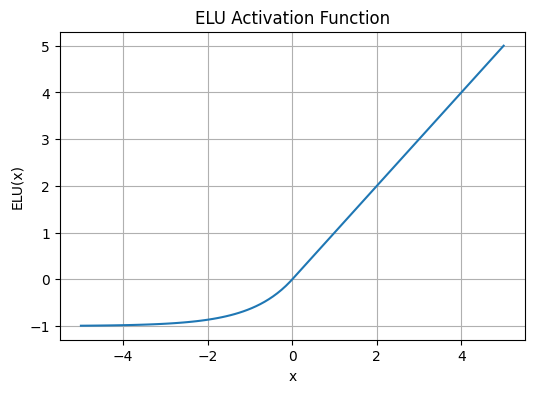

In [21]:
# prompt: narysuj funkcję elu

import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-5, 5, 100)
y_elu = tf.nn.elu(x)
plt.figure(figsize=(6, 4))
plt.plot(x, y_elu)
plt.title('ELU Activation Function')
plt.xlabel('x')
plt.ylabel('ELU(x)')
plt.grid(True)
plt.show()

BARDZO MAŁY MODEL -> tiny

In [22]:
from keras.src.metrics.confusion_metrics import activations
tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
size_histories = {}

In [24]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5010,  binary_crossentropy:0.7645,  loss:0.7645,  val_accuracy:0.5160,  val_binary_crossentropy:0.7186,  val_loss:0.7186,  
..

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


..................................................................................................
Epoch: 100, accuracy:0.6000,  binary_crossentropy:0.6277,  loss:0.6277,  val_accuracy:0.5830,  val_binary_crossentropy:0.6276,  val_loss:0.6276,  
....................................................................................................
Epoch: 200, accuracy:0.6367,  binary_crossentropy:0.6095,  loss:0.6095,  val_accuracy:0.6180,  val_binary_crossentropy:0.6132,  val_loss:0.6132,  
....................................................................................................
Epoch: 300, accuracy:0.6526,  binary_crossentropy:0.5964,  loss:0.5964,  val_accuracy:0.6330,  val_binary_crossentropy:0.6057,  val_loss:0.6057,  
....................................................................................................
Epoch: 400, accuracy:0.6654,  binary_crossentropy:0.5905,  loss:0.5905,  val_accuracy:0.6430,  val_binary_crossentropy:0.6015,  val_loss:0.6015,  
..........

In [25]:
print(size_histories)

{'Tiny': <keras.src.callbacks.history.History object at 0x791ff0a133e0>}


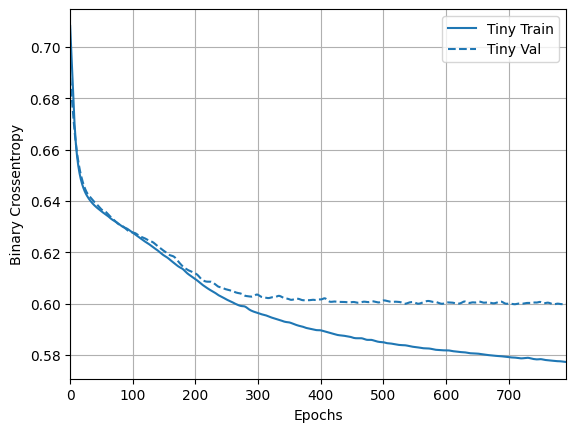

In [26]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std = 10)
plotter.plot(size_histories)
# plt.ylim([0.5,0.7])

MAŁY MODEL

In [27]:
small_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(16,activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['Small'] = compile_and_fit(small_model,'sizes/Small')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4985,  binary_crossentropy:0.7373,  loss:0.7373,  val_accuracy:0.4780,  val_binary_crossentropy:0.7151,  val_loss:0.7151,  
....................................................................................................
Epoch: 100, accuracy:0.6210,  binary_crossentropy:0.6139,  loss:0.6139,  val_accuracy:0.5950,  val_binary_crossentropy:0.6048,  val_loss:0.6048,  
....................................................................................................
Epoch: 200, accuracy:0.6724,  binary_crossentropy:0.5829,  loss:0.5829,  val_accuracy:0.6620,  val_binary_crossentropy:0.5834,  val_loss:0.5834,  
....................................................................................................
Epoch: 300, accuracy:0.6821,  binary_crossentropy:0.5735,  loss:0.5735,  val_accuracy:0.6600,  val_binary_crossentropy:0.5850,  val_loss:0.5850,  
............................................................................

MODEL ŚREDNI -  medium



In [29]:
medium_model = tf.keras.Sequential([
    layers.Dense(64,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(64,activation='elu'),
    layers.Dense(64,activation='elu'),
    layers.Dense(1)
])

In [30]:
size_histories['Medium'] = compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5051,  binary_crossentropy:0.6957,  loss:0.6957,  val_accuracy:0.5130,  val_binary_crossentropy:0.6821,  val_loss:0.6821,  
....................................................................................................
Epoch: 100, accuracy:0.7186,  binary_crossentropy:0.5310,  loss:0.5310,  val_accuracy:0.6370,  val_binary_crossentropy:0.5997,  val_loss:0.5997,  
....................................................................................................
Epoch: 200, accuracy:0.7809,  binary_crossentropy:0.4387,  loss:0.4387,  val_accuracy:0.6580,  val_binary_crossentropy:0.6816,  val_loss:0.6816,  
....................................................................

DUZY MODEL - large

In [31]:
large_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(1)
])

In [32]:
size_histories['Large'] = compile_and_fit(large_model,'sizes/Large')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5033,  binary_crossentropy:0.8221,  loss:0.8221,  val_accuracy:0.5630,  val_binary_crossentropy:0.6899,  val_loss:0.6899,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0025,  loss:0.0025,  val_accuracy:0.6560,  val_binary_crossentropy:1.7195,  val_loss:1.7195,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0002,  loss:0.0002,  val_accuracy:0.6550,  val_binary_crossentropy:2.3583,  val_loss:2.3583,  
........................

Text(0.5, 0, 'Epochs(log scale)')

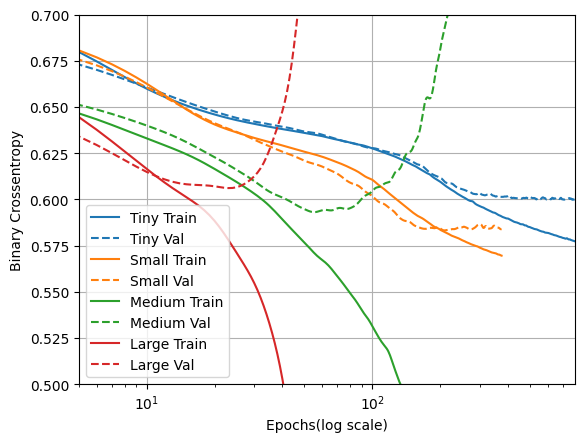

In [33]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epochs(log scale)")

In [34]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp8bvfpc3s/tensorboard_logs/regularizers/Tiny')

In [35]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

REGULARYZACJE WAGI!
DWA WARIANTY REGULARYZACJI WAG: L1, L2
L1 - koszt jest proporcjonalny do bezwzględnej wartości współczynników wag
L2 - koszt jest proporcjonalny do kwadratów wartości współczynników wag

In [36]:
l2_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001),input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model,"regularizers/l2")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4890,  binary_crossentropy:0.8077,  loss:2.3251,  val_accuracy:0.5730,  val_binary_crossentropy:0.6820,  val_loss:2.1209,  
....................................................................................................
Epoch: 100, accuracy:0.6622,  binary_crossentropy:0.5910,  loss:0.6160,  val_accuracy:0.6760,  val_binary_crossentropy:0.5838,  val_loss:0.6089,  
....................................................................................................
Epoch: 200, accuracy:0.6748,  binary_crossentropy:0.5789,  loss:0.6028,  val_accuracy:0.6740,  val_binary_crossentropy:0.5747,  val_loss:0.5987,  
....................................................................................................
Epoch: 300, accuracy:0.6876,  binary_crossentropy:0.5730,  loss:0.5979,  val_accuracy:0.6800,  val_binary_crossentropy:0.5756,  val_loss:0.6004,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

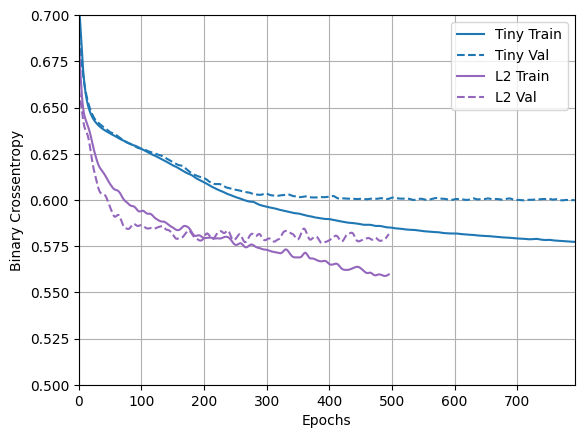

In [37]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])

ingerencja w sieci przetrenowane - dropout (odrzucenie)

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model,"regularizers/dropout")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5184,  binary_crossentropy:0.7960,  loss:0.7960,  val_accuracy:0.5160,  val_binary_crossentropy:0.6789,  val_loss:0.6789,  
....................................................................................................
Epoch: 100, accuracy:0.6601,  binary_crossentropy:0.5944,  loss:0.5944,  val_accuracy:0.6900,  val_binary_crossentropy:0.5786,  val_loss:0.5786,  
....................................................................................................
Epoch: 200, accuracy:0.6894,  binary_crossentropy:0.5573,  loss:0.5573,  val_accuracy:0.6670,  val_binary_crossentropy:0.5797,  val_loss:0.5797,  
....................................................................................................
Epoch: 300, accuracy:0.7184,  binary_crossentropy:0.5143,  loss:0.5143,  val_accuracy:0.6880,  val_binary_crossentropy:0.6010,  val_loss:0.6010,  
......................

(0.5, 0.7)

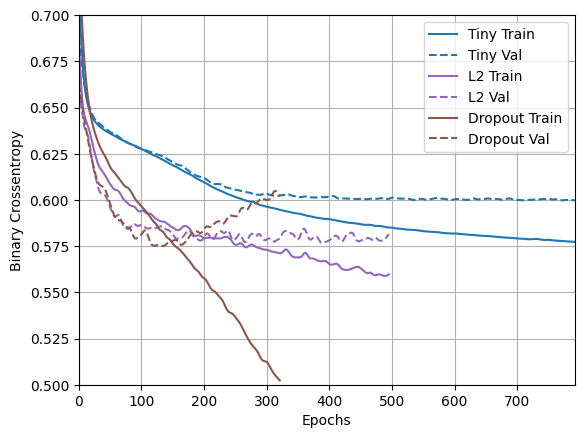

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])

In [50]:
l2_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001),input_shape=(FEATURES,)),
    layers.Dropout(0.2),
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(512,activation='elu',kernel_regularizer = regularizers.l2(0.001)),
    # Removed Reshape, Conv1D, and MaxPooling1D layers
    layers.Dense(1)
])

regularizer_histories['l2_drop'] = compile_and_fit(l2_model,"regularizers/l2_drop")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5038,  binary_crossentropy:0.7537,  loss:2.2593,  val_accuracy:0.5300,  val_binary_crossentropy:0.6677,  val_loss:2.0797,  
..

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


..................................................................................................
Epoch: 100, accuracy:0.5807,  binary_crossentropy:0.6371,  loss:0.6487,  val_accuracy:0.5800,  val_binary_crossentropy:0.6246,  val_loss:0.6363,  
....................................................................................................
Epoch: 200, accuracy:0.5898,  binary_crossentropy:0.6344,  loss:0.6467,  val_accuracy:0.5730,  val_binary_crossentropy:0.6187,  val_loss:0.6309,  
....................................................................................................
Epoch: 300, accuracy:0.6113,  binary_crossentropy:0.6241,  loss:0.6413,  val_accuracy:0.6340,  val_binary_crossentropy:0.6012,  val_loss:0.6184,  
....................................................................................................
Epoch: 400, accuracy:0.6366,  binary_crossentropy:0.6125,  loss:0.6319,  val_accuracy:0.6260,  val_binary_crossentropy:0.6002,  val_loss:0.6198,  
..........

(0.5, 0.7)

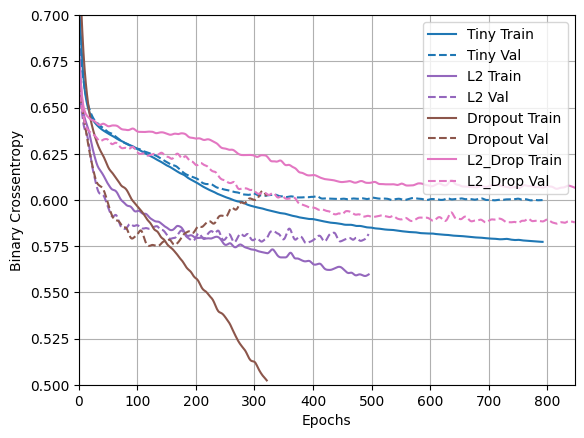

In [51]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])